In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr


In [3]:
file = './rhum.mon.mean.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['lon'],dataset.variables['lat']
time = dataset.variables['time']
level =dataset.variables['level']
rhum = dataset.variables['rhum']

cor_num = pd.read_excel(io = r'./ACE.xlsx')
coordinate = cor_num['WP-NA'].tolist()

In [4]:
# num_month = time[:].data.shape[0] # 时间的size
num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
# 第二阶段从613开始到 900结束
# 因为列表从0开始计算，故第一阶段时间区间为[612, 899]
num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数

# 选择level是700

ls_mean_year = []
for i in range(420, 420+num_month_1997to1982+num_month_2021to1998, 12): 
    sum_month_year =  np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C')
    for month in range(12):
        tmp_month = i + month
        tmp_pre = rhum[tmp_month:tmp_month+1,3:4].data[0][:,:]
        sum_month_year += tmp_pre
    mean_year = sum_month_year / 12
#     mean_year = mean_year.tolist()
    ls_mean_year.append(mean_year[0])

ls_mean_year = np.array(ls_mean_year)
reshape_mean = ls_mean_year.transpose(1,2,0)

In [26]:
reshape_mean.shape

(73, 144, 40)

In [5]:
pearson_matrix = np.zeros((73,144), dtype=float, order='C')
p_value = np.zeros((73,144), dtype=float, order='C')
for i in range(len(reshape_mean)):
    for j in range(len(reshape_mean[i])):
        x = reshape_mean[i][j]
        y = coordinate
        tmp_correlation, _ = pearsonr(x, y)
#         print(tmp_correlation)
        pearson_matrix[i][j] = tmp_correlation
        p_value[i][j] = _
pearson_matrix = np.nan_to_num(pearson_matrix)

In [40]:
lon = longitude[:].data
lat = latitude[:].data

print(len(lon), len(lat), pearson_matrix.shape)
print(pearson_matrix.max(), pearson_matrix.min())

144 73 (73, 144)
0.7007592694159838 -0.6315523408603356


In [44]:
data

array([[-0.01451526, -0.01451526, -0.01451526, ..., -0.01451526,
        -0.01451526, -0.01451526],
       [-0.08545698, -0.09178962, -0.09807914, ..., -0.0634779 ,
        -0.07137528, -0.0788377 ],
       [-0.12279765, -0.11839635, -0.11203258, ..., -0.11721763,
        -0.12045337, -0.122664  ],
       ...,
       [-0.439664  , -0.38645142, -0.3355048 , ..., -0.48421089,
        -0.49051411, -0.4616191 ],
       [-0.28262561, -0.28030289, -0.27963396, ..., -0.29340845,
        -0.28887297, -0.28366096],
       [-0.25052127, -0.25052127, -0.25052127, ..., -0.25052127,
        -0.25052127, -0.25052127]])

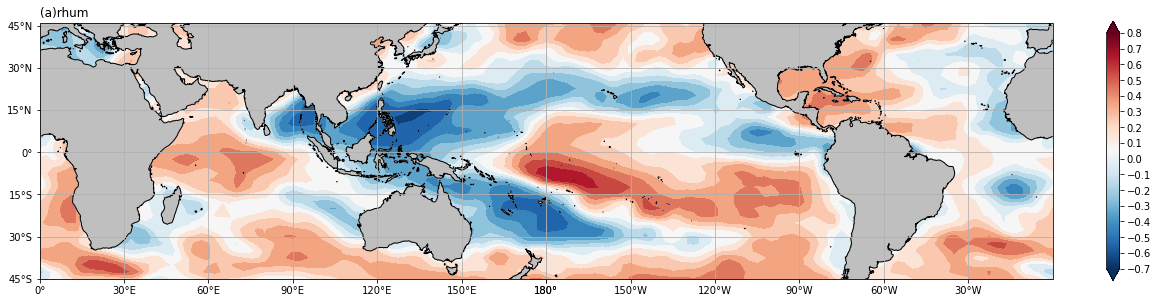

In [50]:
# lon = longitude[:].data
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

data = pearson_matrix 

# 调整经纬度 向东偏移180
# diff_2d = data[0]
new_data=[]
for i in range(data.shape[0]):
    tmp = np.append(data[i], data[i][0])
    new_data.append(tmp.tolist())
new_data = np.array(new_data)

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181.1, -45,46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a)rhum',loc='left',fontsize =12)
 
cont = fig_ax1.contourf(lon, lat, new_data, 
                 levels=np.arange(-0.70, 0.801, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.70, vmax=0.80)    #确定colormap的最大最小值



fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.70, 0.801, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 


plt.savefig("rhum_correl.png",dpi=300,bbox_inches='tight')
plt.show()

In [12]:
p_value = np.where(p_value < 0.05)

In [6]:
print(p_value.max(), p_value.min())

0.9999721553161243 4.781853905925041e-07


In [8]:
p_value.shape

(73, 144)

In [11]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i in range(73):
    for j in range(144):
        if p_value[i][j] > 0.1:
            count1 += 1
        elif p_value[i][j] <= 0.1 and p_value[i][j] > 0.01:
            count2 += 1
        elif p_value[i][j] <= 0.01 and p_value[i][j] > 0.001:
            count3 += 1
        else:
            count4 += 1
            
print(count1, count2, count3, count4)

7361 2354 600 197


In [13]:
p_value

(array([ 3,  3,  3, ..., 70, 70, 70]),
 array([ 93,  94,  95, ..., 141, 142, 143]))

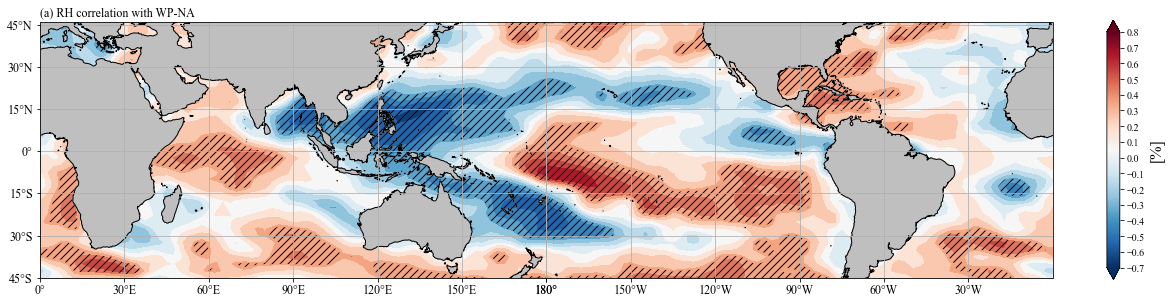

In [9]:

from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
# lon = longitude[:].data
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

data = pearson_matrix 

# 调整经纬度 向东偏移180
# new_data = data
new_data=[]
for i in range(data.shape[0]):
    tmp = np.append(data[i], data[i][0])
    new_data.append(tmp.tolist())
# new_data = np.array(new_data)

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181.1, -45,46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.contourf(longitude[:].data, lat, p_value,
                [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree())

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]


fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) RH correlation with WP-NA',loc='left',fontsize =12)
 
cont = fig_ax1.contourf(lon, lat, new_data, 
                 levels=np.arange(-0.70, 0.801, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.70, vmax=0.80)    #确定colormap的最大最小值

# m_lon, m_lat = np.meshgrid(lon, lat)
# p_val= np.where(p_value < 0.05)
# fig_ax1.scatter(m_lon[p_val], m_lat[p_val], color='k',
#                s = 1.2, 
#                 linewidths=2.5,
#                transform=ccrs.PlateCarree())

# fig_ax1.contourf(longitude[:].data, lat, p_value,
#                 [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
# #                  [0.01, 0.05, np.nanmax(p_value)],
#                 hatches=['///', None], colors="none",
#                 transform = ccrs.PlateCarree())



fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.70, 0.801, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[%]", fontdict=font) #设置colorbar的标签字体及其大小

plt.savefig("rhum_correl.png",dpi=300,bbox_inches='tight')
plt.show()

In [36]:
[np.nanmin(p_value), 0.05, np.nanmax(p_value)]

[4.781853905925041e-07, 0.05, 0.9999721553161243]

In [40]:
[0.01, 0.05, np.nanmax(p_value)],

([0.01, 0.05, 0.9999721553161243],)